# Dataviz coronavirus

In [2]:
import io
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats
import scipy.special
import seaborn as sns

## Recupero dati

In [30]:

import requests
api = requests.get("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-json/dpc-covid19-ita-andamento-nazionale.json")
data = pd.read_json(api.text)
data['data'] = data['data'].map(lambda x: x.lstrip('(2020)').rstrip('(18:00:00)(17:00:00)'))
data

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,-02-24,ITA,101,26,127,94,221,221,1,7,229,4324
1,-02-25,ITA,114,35,150,162,311,90,1,10,322,8623
2,-02-26,ITA,128,36,164,221,385,74,3,12,400,9587
3,-02-27,ITA,248,56,304,284,588,203,45,17,650,12014
4,-02-28,ITA,345,64,409,412,821,233,46,21,888,15695
5,-02-29,ITA,401,105,506,543,1049,228,50,29,1128,18661
6,-03-01,ITA,639,140,779,798,1577,528,83,34,1694,21127
7,-03-02,ITA,742,166,908,927,1835,258,149,52,2036,23345
8,-03-03,ITA,1034,229,1263,1000,2263,428,160,79,2502,25856
9,-03-04,ITA,1346,295,1641,1065,2706,443,276,107,3089,29837


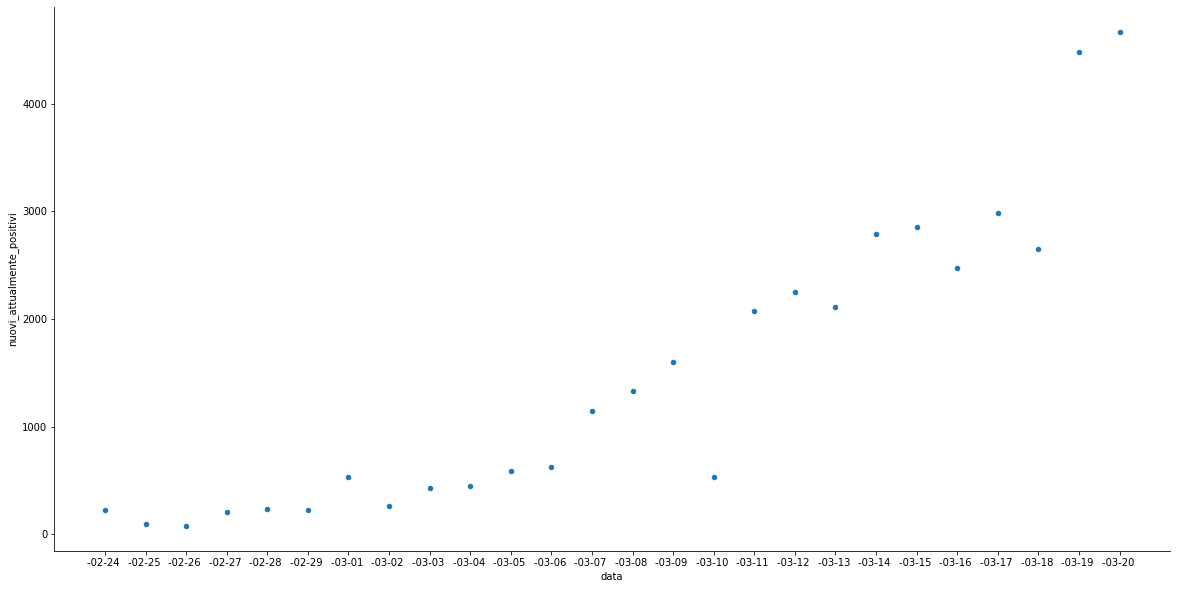

In [26]:
plt.rcParams["figure.figsize"] = (20,10)
data.plot.scatter('data', 'nuovi_attualmente_positivi')
sns.despine()

